## **Sign Language Recognition**

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pickle

import os
import random
import matplotlib.pyplot as plt

In [11]:
COMPETITION_PATH = '/kaggle/input/asl-signs/'
PROCESS_DATASET_PATH = "/kaggle/input/preprocess-dataset/preprocess_dataset.pkl"
dataset_path = '/kaggle/input/asl-signs/train_landmark_files'
user_ids = os.listdir('/kaggle/input/asl-signs/train_landmark_files')

## Function to load sequence provided by Google

In [12]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [13]:
def select_random_sequence():
    usr = random.choice(user_ids)
    usr_sqc = os.listdir(os.path.join(dataset_path,usr))
    sqc = random.choice(usr_sqc)
    return os.path.join(dataset_path,usr,sqc)

In [14]:
select_random_sequence()

'/kaggle/input/asl-signs/train_landmark_files/37055/3500572968.parquet'

In [15]:
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
pq_path = select_random_sequence()
df = pd.read_parquet(pq_path, columns=cols)
print(pq_path)
print(f'xmax: {np.max(df.x)}\nymax: {np.max(df.y)}\nxmin: {np.min(df.x)}\nymin: {np.min(df.y)}')

/kaggle/input/asl-signs/train_landmark_files/26734/3784164935.parquet
xmax: 1.4504083395004272
ymax: 2.197863817214966
xmin: 0.02461213618516922
ymin: 0.2683626413345337


### **Do not run next cell (takes time)**
or maybe run it one time for min values

In [16]:
# maxX=[]
# maxY=[]
# maxZ=[]
# for usr in user_ids:
#     usr_sqc = os.listdir(os.path.join(dataset_path,usr))
#     for sqc in usr_sqc:
#         pth = os.path.join(dataset_path,usr,sqc)
#         df = pd.read_parquet(pth, columns=['x', 'y', 'z'])
#         maxX.append(np.max(df.x))
#         maxY.append(np.max(df.y))
#         maxZ.append(np.max(df.z))

# print(f'max x: {np.max(maxX)}\nmax y: {np.max(maxY)}\nmax z: {np.max(maxZ)}')

'''
outputs:

max x: 2.9205052852630615
max y: 3.572496175765991
max z: 4.796591758728027
'''

'\noutputs:\n\nmax x: 2.9205052852630615\nmax y: 3.572496175765991\nmax z: 4.796591758728027\n'

### **Prepocessing**

In [17]:
# lips idx
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# left hand, by taking account face from 0 to 468
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

REDUCED_LANDMARKS = np.sort(np.concatenate([LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0]))
print(REDUCED_LANDMARKS)

[  0  13  14  17  37  39  40  61  78  80  81  82  84  87  88  91  95 146
 178 181 185 191 267 269 270 291 308 310 311 312 314 317 318 321 324 375
 402 405 409 415 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 482 483 484 485 486 487 488 502 503 504 505 506 507 508 509 510 511 522
 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 542]


**Note** positions kept as wanted

In [18]:
def normalize_sequence(sequence_dataframe):
    '''
        function to normalize coordinates columns (x,y) per frame, also replace NaN values by column mean
        sequence_dataset is a pandas dataframe containing a sequence of an user
    '''



    frame_sqc_idx = sqc_df.frame.unique()
    normalized_df = pd.DataFrame()

    for frame in frame_sqc_idx:
        frame_df = sqc_df[sqc_df.frame == frame]
        frame_df1 = frame_df.copy()
        
        na_x = frame_df['x'].fillna(0.0)
        na_y = frame_df['y'].fillna(0.0)

        x_norm = (na_x-np.min(na_x))/(np.max(na_x)-np.min(na_x))
        y_norm = (na_y-np.min(na_y))/(np.max(na_y)-np.min(na_y))

        frame_df1.x, frame_df1.y = x_norm, y_norm
        normalized_df = pd.concat([normalized_df, frame_df1])
    
    return normalized_df

In [19]:
def normalize_loaded_sequence(loaded_sqc):
    '''
        Function to normalize using min-max normalization. 
        Normalization is calculated over all points, but only relevants landmarks points are returned
        This function also replaces NaN by 0
    '''
    normalized_sqc = np.zeros((loaded_sqc.shape[0], len(REDUCED_LANDMARKS), 2))
    
    for frm_idx in range(loaded_sqc.shape[0]):
        frame_array = loaded_sqc[frm_idx]
        
        na_x = np.nan_to_num(frame_array[:,0], nan=0.0)
        na_y = np.nan_to_num(frame_array[:,1], nan=0.0)


        x_norm = (na_x-np.min(na_x))/(np.max(na_x)-np.min(na_x))
        y_norm = (na_y-np.min(na_y))/(np.max(na_y)-np.min(na_y))

        normalized_sqc[frm_idx,:,0],  normalized_sqc[frm_idx,:,1] = x_norm[REDUCED_LANDMARKS], y_norm[REDUCED_LANDMARKS]
    
    return normalized_sqc

**Note** at this step I have a normalized tensor built after loading data

In [20]:
def get_data(sqc_path):
    data = load_relevant_data_subset(sqc_path)
    data = normalize_loaded_sequence(data)
    return data

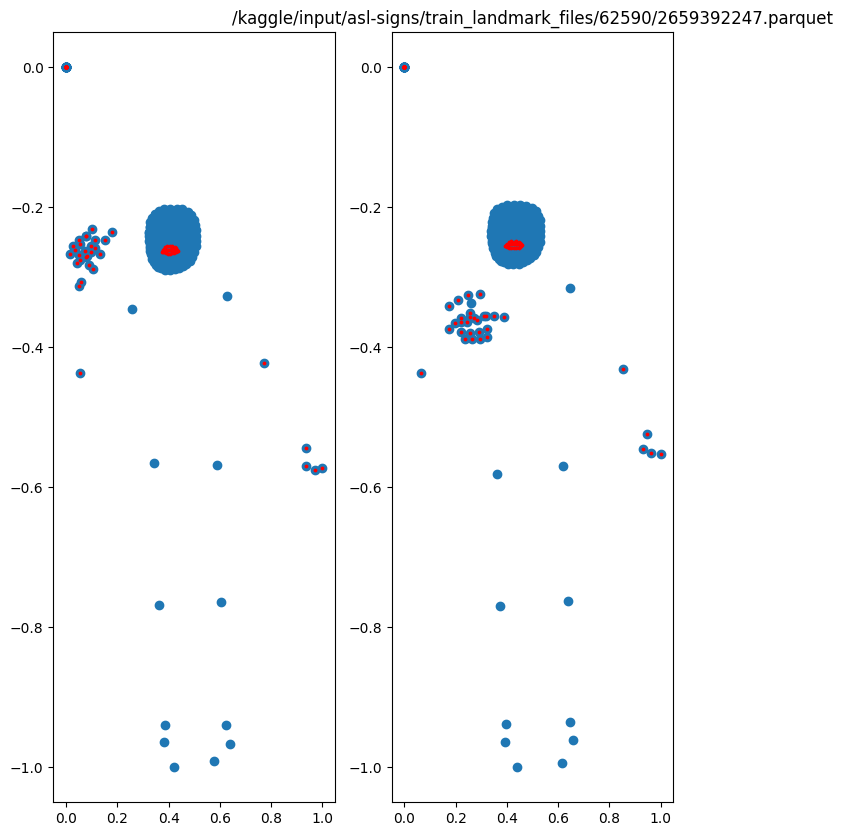

In [21]:
pq_path = select_random_sequence() # only first sequence of user here
cols = ['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
sqc_df = pd.read_parquet(pq_path, columns=cols)

vv = get_data(pq_path)

n_df = normalize_sequence(sqc_df)
frame_df0 = n_df[n_df.frame == n_df.frame.unique()[0]]
frame_df1 = n_df[n_df.frame == n_df.frame.unique()[-1]]

X0 = frame_df0.x
Y0= frame_df0.y

X1 = frame_df1.x
Y1= frame_df1.y

plt.figure(figsize=(8,10))
plt.subplot(1,2,1)
plt.scatter(X0,-Y0)
plt.scatter(vv[0,:,0],-vv[0,:,1], s=3, c='r')

plt.subplot(1,2,2)
plt.scatter(X1,-Y1)
plt.scatter(vv[-1,:,0],-vv[-1,:,1], s=3, c='r')

plt.title(pq_path)
plt.show()

#### **Note** 
Normalization using min-max change position of point when using less (but most important) landmarks, is it normal as we used less points.
But movement keep the same

- RNN or LSTM can be a good simple approach for starting (it can be adapted for Time Series)

#### **TODO**
* thing about data augmentation
* try to use coatnet -> need to input data with same shape
* padding ?
    - issue with padding is that we have sequence with much more frames than other, maybe reduce thoses sequences and padding for small sequences
    - goal: have se

In [22]:
train_path = '/kaggle/input/asl-signs/train.csv'
train = pd.read_csv(train_path)
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [23]:
d=dict(train.sign.value_counts(dropna=True))
print(train.sign.value_counts(dropna=True).mean())
print(train.sign.value_counts(dropna=True).std())
print(train.sign.value_counts(dropna=True).max())
print(train.sign.value_counts(dropna=True).min())

# word distribution is not too expended
# any words have close occurences

377.908
19.39536689593967
415
299


#### **Some notes:**
* each parquet contains markers position [x y z] and type (face, left_hand, pose, right_hand) for different frame
* train dataset is composed of image path, participant id (folder name of parquet file) sequence id (filename) and word said
* one sequence = numerous frames = 1 word
* every frame has data for each type, but it is possible that one type has no value in a frame, it is setted to NaN

**Goal**: using hand position, be able to understand word said in the sequence
* classification between 250 words using positions of body parts in video

In [24]:
import json
 
# Opening JSON file
f = open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json')
 
# returns JSON object as 
# a dictionary
WORD2IDX = json.load(f)
print(len(WORD2IDX), WORD2IDX)

250 {'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 7

In [25]:
train_words = train.sign.unique()
print(len(train_words))
# same length as sign to prediction index json

250


In [26]:
random_word = random.choice(train.sign.unique())
print(f'idx for <{random_word}> is <{WORD2IDX[random_word]}>')

idx for <wolf> is <242>


### Custom Dataset class

### **Don't run following cell, it creates *preprocess_dataset***

In [27]:
# Do not run !

# processed_dataset = []
# for idx,path in enumerate(train.path):
#     sequence_path = os.path.join(COMPETITION_PATH, path)
#     word = train[train.path == path].sign.values[0]
#     processed_sqc = get_data(sequence_path)
    
#     processed_dataset.append((processed_sqc, word))
    
#     if idx%200 == 0:
#         print(processed_sqc.shape, word)

In [28]:
# to save dataset
# with open("preprocess_dataset.pkl", "wb") as fp:   #Pickling
#     pickle.dump(processed_dataset, fp)

In [29]:
# to load dataset
with open(PROCESS_DATASET_PATH, "rb") as fp:   # Unpickling
    dataset = pickle.load(fp)

### **Custom class and Dataloader**

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [31]:
class ISLR(Dataset):
    def __init__(self, dataset, split):
        self.split = split
        self.dataset = dataset
        
        if split == 'trainval':
            self.islr_dataset = dataset[:int(0.8*len(dataset))]
        elif split =='test':
            self.islr_dataset = dataset[int(0.8*len(dataset)):]
        
    def __len__(self):
        return len(self.islr_dataset)
    
    def __getitem__(self, index):
        sample = self.islr_dataset[index]
        features = torch.FloatTensor(sample[0])
        target = WORD2IDX[sample[1]]
        
        return features, target

In [32]:
testset = ISLR(dataset, split='test')
trainvalset = ISLR(dataset, split='trainval')

In [33]:
trainset, valset = train_test_split(trainvalset,test_size=0.1, random_state=42)

In [34]:
len(trainset),len(valset)

(68022, 7559)

In [35]:
def custom_collate_fn(batch):
    padded_batch = []
    labels= []

    max_frame = max(len(sequence) for sequence,_ in batch)
#     print(max_frame)
    for sequence, label in batch:
        padding_array = -np.ones(((max_frame-len(sequence)), len(REDUCED_LANDMARKS), 2))
        padded_sequence = sequence.tolist()+padding_array.tolist()

        padded_batch.append(padded_sequence)
        labels.append(label)


    return torch.tensor(padded_batch), torch.tensor(labels)

In [36]:
train_loader = DataLoader(trainset, 
                          batch_size=8, 
                          collate_fn=custom_collate_fn, 
                          shuffle=True,
                          num_workers=4)

In [37]:
val_loader = DataLoader(valset,
                        batch_size=8,
                        collate_fn=custom_collate_fn,
                        shuffle=False,
                        num_workers=4)

In [38]:
test_loader = DataLoader(testset,
                         batch_size=8,
                         collate_fn=custom_collate_fn,
                         shuffle=False,
                         num_workers=4)

In [39]:
custom_it = enumerate(train_loader)

In [40]:
idx,(sqc,lb)=next(custom_it)
print(sqc.shape, lb)

torch.Size([8, 236, 92, 2]) tensor([ 88,  97, 232,  24, 100, 131,  22,  33])


### **Model architecture**

### Transformer

In [41]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, output_dim, n_landmarks, max_seq_length=1000):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim*n_landmarks, hidden_dim) # change encoding 
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.positional_encoding = self.create_positional_encoding(max_seq_length, hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # activation softmax
        
        
    def forward(self, x):
        
        batch_size, n_frames, n_landmarks, input_dim = x.shape
        pad_mask = self.sequence_mask(x)
        pad_mask = pad_mask.to(device)
        
        
        # Flatten n_landmarks and input_dim for embedding
        x = x.view(batch_size, n_frames, -1)
        x = x.to(device)
        x = self.embedding(x)
        
        x = self.layer_norm1(x)
        x += self.positional_encoding[:, :n_frames, :].to(device)
        x = x.permute(1, 0, 2)  # Transformer expects sequence length first
                
        transformer_out = self.transformer_encoder(x,src_key_padding_mask=pad_mask)
        out = self.fc(transformer_out[-1, :, :])
        assert not torch.isnan(out).any(), "NaN in final output"
        
        
        return out
    
    def create_positional_encoding(self, max_seq_length, hidden_dim):
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / hidden_dim))
        
        positional_encoding = torch.zeros(max_seq_length, hidden_dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        
        return positional_encoding.unsqueeze(0)
    
    def sequence_mask(self, sequence):
        lengths = [self.valid_len(padded_sequence) for padded_sequence in sequence]
        
        mask = torch.zeros(sequence.size()[:2], dtype=torch.bool)  # shape: [batch_size, n_frames]
        for i, length in enumerate(lengths):
            mask[i, :length] = 1
        
        mask = ~mask # True values are ignored
        return mask

        
    def valid_len(self, padded_sequence):
        for idx, frame in  enumerate(padded_sequence):
            if -1 in frame:
                break

        return idx+1

In [ ]:
input_dim = 2  # (x, y)
num_heads = 4
num_layers = 2
hidden_dim = 64
output_dim = 250  # number of classes
n_landmarks = 92


model1 = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1 = model1.to(device)
print(model1)

In [ ]:
# smaller model, model2

num_heads = 2
num_layers = 1
hidden_dim = 32


model2 = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = model2.to(device)
print(model2)

In [ ]:
out  = model(sqc)

### 1D CNN

In [ ]:
class SignLanguageCNN1D(nn.Module):
    def __init__(self, n_landmarks, input_dim, num_classes):
        super(SignLanguageCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256 * n_landmarks, 512)  # Note: Adjusted for dynamic sequence length
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        batch_size, n_frames, n_landmarks, input_dim = x.size()
        x = x.permute(0, 3, 1, 2)  # Change from [batch_size, n_frames, n_landmarks, input_dim] to [batch_size, input_dim, n_frames, n_landmarks]
        x = x.reshape(batch_size * n_landmarks, input_dim, n_frames)  # Combine batch and landmarks for 1D conv
        x = self.pool(F.relu(self.conv1(x)))  # Output shape: [batch_size * n_landmarks, 64, n_frames//2]
        x = self.pool(F.relu(self.conv2(x)))  # Output shape: [batch_size * n_landmarks, 128, n_frames//4]
        x = self.pool(F.relu(self.conv3(x)))  # Output shape: [batch_size * n_landmarks, 256, n_frames//8]
        x = self.adaptive_pool(x)  # Output shape: [batch_size * n_landmarks, 256, 1]
        x = x.view(batch_size, n_landmarks, -1)  # Reshape back to [batch_size, n_landmarks, feature_dim]
#         print(x.shape)
        x = x.view(batch_size, -1)  # Flatten to [batch_size, n_landmarks * feature_dim]
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
n_landmarks = dataset[0][0].shape[1]
input_dim = dataset[0][0].shape[2]
num_classes = 250

### **Training Phase**

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 5

dataloader = train_loader

for epoch in range(num_epochs):

    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    model.train()
    running_loss = 0.0

    for sequence, label in dataloader:
        sequence, label = sequence.to(device), label.to(device)
        optimizer.zero_grad()

        target = label
        
        outputs = model(sequence)

#         predictions = torch.argmax(outputs, dim=1) # get index of max word

        # Compute the loss, gradients, and update optimizer
        loss = loss_function(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
#         running_corrects += torch.sum(predictions == label)

#     exp_lr_scheduler.step()

    epoch_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
    
    # Validation step
    model.eval()
    val_loss = 0.0
    correct5 = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for sequence, label in val_loader:
            sequence, label = sequence.to(device), label.to(device)
            outputs = model(sequence)
            loss = loss_function(outputs, label)
            val_loss += loss.item() * sequence.size(0)
            
#           use top 5 pred maybe
            _, predicted5 = torch.topk(outputs, 5, dim=1)

            total += label.size(0)
            correct5 += (predicted5.to(device) == label.view(-1, 1)).sum().item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == label).sum().item()
            
    val_loss /= len(val_loader.dataset)
    val_acc = correct /total
    val_acc_top5 = correct5/total
    print(f'val loss: {val_loss:.4f} Acc: {val_acc:.4f} Top 5 Acc: {val_acc_top5:.4f}')
    
    torch.save(model.state_dict(), f'pointnet_transformer_model_{epoch+1}.pth')

In [ ]:
'''
Epoch 0/4
----------
Epoch 1/5, Training Loss: 5.5489
val loss: 5.5252 Acc: 0.6634
Epoch 1/4
----------
Epoch 2/5, Training Loss: 5.5313
val loss: 5.5213 Acc: 0.6592
Epoch 2/4
----------
Epoch 3/5, Training Loss: 5.4685
val loss: 5.3126 Acc: 0.7019
Epoch 3/4
----------
Epoch 4/5, Training Loss: 5.0170
val loss: 4.6766 Acc: 0.8116
Epoch 4/4
----------
Epoch 5/5, Training Loss: 4.4992
val loss: 4.2321 Acc: 0.9436
'''

### Train several models to compare

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
MODEL1_PATH = "/kaggle/input/islr_transformer_model1_30epochs/pytorch/model1_45ep/1/pointnet_transformer_model1_45.pth"
MODEL2_PATH = "/kaggle/input/islr_transformer_model2/pytorch/model2_45ep/1/pointnet_transformer_model2_45.pth"

In [ ]:
input_dim = 2  # (x, y)
num_heads = 4
num_layers = 2
hidden_dim = 64
output_dim = 250
n_landmarks = 92

model1 = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

model1.load_state_dict(torch.load(MODEL1_PATH))

In [ ]:
input_dim = 2  # (x, y)
num_heads = 2
num_layers = 1
hidden_dim = 32
output_dim = 250
n_landmarks = 92

model2 = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

model2.load_state_dict(torch.load(MODEL2_PATH))

In [ ]:
model1.to(device)
model2.to(device)

In [ ]:
o1 = model1(sqc)
o2 = model2(sqc)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optim1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
optim2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
num_epochs = 15

dataloader = train_loader

for epoch in range(num_epochs):

    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    model1.train()
    model2.train()
    
    running_l1 = 0.0
    running_l2 = 0.0

    for sequence, label in dataloader:
        sequence, label = sequence.to(device), label.to(device)
        
        optim1.zero_grad()
        optim2.zero_grad()


        target = label
        
        out1 = model1(sequence)
        out2 = model2(sequence)


        # Compute the loss, gradients, and update optimizer
        loss1 = loss_function(out1, target)
        loss2 = loss_function(out2, target)

        loss1.backward()
        loss2.backward()
        
        optim1.step()
        optim2.step()

    
        running_l1 += loss1.item()
        running_l2 += loss2.item()
        


    epoch_l1 = running_l1 / len(dataloader)
    epoch_l2 = running_l2 / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_l1:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_l2:.4f}")

    
    # Validation step
    model1.eval()
    model2.eval()

    val_loss1 = 0.0
    correct_top5_mod1 = 0
    correct_mod1 = 0
    
    val_loss2 = 0.0
    correct_top5_mod2 = 0
    correct_mod2= 0
    
    total = 0
    
    with torch.no_grad():
        for sequence, label in val_loader:
            sequence, label = sequence.to(device), label.to(device)
            
            out1 = model1(sequence)
            out2 = model2(sequence)

            loss1 = loss_function(out1, label)
            loss2 = loss_function(out2, label)

            val_loss1 += loss1.item() * sequence.size(0)
            val_loss2 += loss2.item() * sequence.size(0)

            
#           use top 5 pred
            _, pred1_top5 = torch.topk(out1, 5, dim=1)
            _, pred2_top5 = torch.topk(out2, 5, dim=1)

            correct_top5_mod1 += (pred1_top5.to(device) == label.view(-1, 1)).sum().item()
            correct_top5_mod2 += (pred2_top5.to(device) == label.view(-1, 1)).sum().item()

#             top prediction
            _, pred1 = torch.max(out1, 1)
            _, pred2 = torch.max(out2, 1)

            correct_mod1 += (pred1 == label).sum().item()
            correct_mod2 += (pred2 == label).sum().item()
            
            
            total += label.size(0)



    val_loss1 /= len(val_loader.dataset)
    val_loss2 /= len(val_loader.dataset)
    
    val_acc1 = correct_mod1 /total
    val_acc2 = correct_mod2 /total

    val_acc1_top5 = correct_top5_mod1/total
    val_acc2_top5 = correct_top5_mod2/total

    print(f'(model1) val loss: {val_loss1:.4f} Acc: {val_acc1:.4f} Top 5 Acc: {val_acc1_top5:.4f}')
    print(f'(model2) val loss: {val_loss2:.4f} Acc: {val_acc2:.4f} Top 5 Acc: {val_acc2_top5:.4f}')


    torch.save(model1.state_dict(), f'pointnet_transformer_model1_{epoch+1}.pth')
    torch.save(model2.state_dict(), f'pointnet_transformer_model2_{epoch+1}.pth')

#### **Analysis Ideas**

* class embalencement (count words for each element in train dataset)
* size analysis (lenght of sequence, linked to words ?)
* position ranges (x y z)
* number of sequence per participant 
* train dataset will be splitted for train test val

### Load mode and analyze

In [42]:
MODEL1_PATH = "/kaggle/input/islr_transformer_model1_30epochs/pytorch/model1_60ep/1/pointnet_transformer_model1_60.pth"
MODEL2_PATH = "/kaggle/input/islr_transformer_model2/pytorch/model2_45ep/1/pointnet_transformer_model2_45.pth"

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [44]:
input_dim = 2  # (x, y)
num_heads = 4
num_layers = 2
hidden_dim = 64
output_dim = 250
n_landmarks = 92

model_load = TransformerModel(input_dim=input_dim,
                         num_heads=num_heads,
                         num_layers=num_layers,
                         hidden_dim=hidden_dim,
                         output_dim=output_dim,
                         n_landmarks=n_landmarks)

if torch.cuda.is_available():
    model_load.load_state_dict(torch.load(MODEL1_PATH))
else:
    model_load.load_state_dict(torch.load(MODEL1_PATH, map_location=torch.device('cpu')))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
model_load.to(device)

TransformerModel(
  (embedding): Linear(in_features=184, out_features=64, bias=True)
  (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=250, bias=True)
)

In [47]:
correct = 0
total = 0
model_load.eval()
true_labels = []
predicted_labels = []

confusion_matrix = torch.zeros(250, 250)

with torch.no_grad():
      for i, (sequence, label) in enumerate(test_loader):
            sequence, label = sequence.to(device), label.to(device)
            
            outputs = model_load(sequence)

            _, pred = torch.max(outputs, 1)
            correct += (pred == label).sum().item()
            
            true_labels = true_labels+label.tolist()
            predicted_labels = predicted_labels+pred.tolist()

            total += label.size(0)
            
            for t, p in zip(label.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

#             if i%200==0:
#                 print(f'Ground Truth: {label}')
#                 print(f'Prediction: {pred}')
#                 print('-'*10)

print(f'Accuracy of the network on the test set: {100 * correct // total} %')

Accuracy of the network on the test set: 66 %


In [48]:
torch.save(confusion_matrix, "cm_test.pt")

In [50]:
confusion_matrix = torch.load("/kaggle/input/confusion-matrix/cm_test.pt")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels))

In [59]:
import pandas as pd

if "class_report.csv" in os.listdir("/kaggle/input/class-report"):
    print('loading class_report.csv...')
    class_report_df = pd.read_csv("/kaggle/input/class-report/class_report.csv")

loading class_report.csv...


In [60]:
class_report_df.head()

,precision,recall,f1-score,support
0,0.835616,0.813333,0.824324,75.0
1,0.581818,0.492308,0.533333,65.0
2,0.823529,0.717949,0.767123,78.0
3,0.774648,0.696203,0.733333,79.0
4,0.613333,0.547619,0.578616,84.0


In [ ]:
# # Assuming true_labels and predicted_labels are your actual and predicted labels
# report = classification_report(true_labels, predicted_labels, output_dict=True)

# # Convert the report dictionary to a pandas DataFrame
# report_df = pd.DataFrame(report).transpose()

In [ ]:
# report['accuracy']

In [ ]:
# class_report_df = report_df.drop(['accuracy','macro avg', 'weighted avg'])

In [ ]:
# class_report_df.to_csv("/kaggle/working/class_report.csv", header=True, index=False)

In [61]:
f1_score = class_report_df['f1-score']
np.argmin(f1_score)

95

In [62]:
value_to_keep = 5
sorted_classes=np.argsort(f1_score.values)
worst_classes = sorted_classes[:value_to_keep]
best_classes = sorted_classes[-value_to_keep:]

In [63]:
best_classes

array([219,  63, 165,  86,  49])

In [84]:
worst_classes

array([ 95, 216,  21,  80, 231])

In [86]:
support = class_report_df['support']
support.values[worst_classes]

array([64., 73., 61., 81., 69.])

In [65]:
f1_score.values[worst_classes]

array([0.26530612, 0.33070866, 0.33939394, 0.35294118, 0.36619718])

In [66]:
support.values[best_classes]

array([79., 72., 76., 78., 79.])

In [185]:
f1_score.values[best_classes]

array([0.88622754, 0.88732394, 0.91275168, 0.91823899, 0.94039735])

In [ ]:
np.mean(support)

In [ ]:
position = list(WORD2IDX.values()).index(worst_classes[0])

In [58]:
WORD = list(WORD2IDX.keys())
# WORD[position]

In [56]:
def get_word_from_key(key_index):
    position = list(WORD2IDX.values()).index(key_index)
    return WORD[position]

In [73]:
for class_idx in worst_classes:
    print(get_word_from_key(class_idx))

give
there
beside
finger
vacuum


In [184]:
for class_idx in best_classes:
    print(get_word_from_key(class_idx))

tiger
drink
owl
flower
clown


In [ ]:
class_idx = best_classes[1]
word = get_word_from_key(class_idx)
worst_class_path = train[train.sign == word].path.values
sequence_length = []
for idx,sqc_path in enumerate(worst_class_path):
    sequence = get_data(os.path.join(COMPETITION_PATH,sqc_path))
    sequence_length.append(len(sequence))
#     if idx%50==0:
#         print(len(sequence))
        
np.mean(sequence_length)

In [ ]:
def mean_len_word_sqcs(class_index):
    word = get_word_from_key(class_index)
    worst_class_path = train[train.sign == word].path.values
    sequence_length = []
    for idx,sqc_path in enumerate(worst_class_path):
        sequence = get_data(os.path.join(COMPETITION_PATH,sqc_path))
        sequence_length.append(len(sequence))


    return np.mean(sequence_length)

In [ ]:
for class_idx in best_classes:
    print(f'{get_word_from_key(class_idx)} : {mean_len_word_sqcs(class_idx)}')

In [ ]:
for class_idx in worst_classes:
    print(f'{get_word_from_key(class_idx)} : {mean_len_word_sqcs(class_idx)}')

### Results analysis

In [51]:
per_class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)

In [52]:
per_class_acc

tensor([0.8133, 0.4923, 0.7179, 0.6962, 0.5476, 0.4189, 0.6667, 0.6533, 0.8113,
        0.7869, 0.8222, 0.5600, 0.5714, 0.6974, 0.6533, 0.6818, 0.7000, 0.7538,
        0.5393, 0.7568, 0.6615, 0.4590, 0.8143, 0.8721, 0.8986, 0.6951, 0.6944,
        0.5833, 0.6301, 0.7391, 0.6582, 0.9125, 0.7308, 0.6892, 0.7857, 0.7922,
        0.7763, 0.6506, 0.4051, 0.6456, 0.4681, 0.6462, 0.5439, 0.4493, 0.8056,
        0.5833, 0.5278, 0.6800, 0.5541, 0.8987, 0.8286, 0.7975, 0.7073, 0.6203,
        0.8308, 0.7714, 0.7465, 0.7353, 0.6125, 0.8649, 0.7582, 0.8000, 0.6180,
        0.8750, 0.5658, 0.6389, 0.5972, 0.4444, 0.6234, 0.7397, 0.4483, 0.6471,
        0.7273, 0.5385, 0.4691, 0.7579, 0.4321, 0.6429, 0.7556, 0.7407, 0.2593,
        0.7356, 0.7529, 0.8043, 0.5484, 0.7105, 0.9359, 0.7500, 0.8772, 0.8684,
        0.8056, 0.7183, 0.6420, 0.6970, 0.6804, 0.2031, 0.5897, 0.3896, 0.5476,
        0.6029, 0.6901, 0.7013, 0.6786, 0.7848, 0.8000, 0.7273, 0.7714, 0.5652,
        0.6709, 0.5000, 0.7875, 0.4557, 

In [53]:
class_acc, worst_classes = torch.topk(1-per_class_acc, k=5)
class_acc = 1-class_acc

In [54]:
worst_classes

tensor([ 95,  80, 134, 216, 167])

In [113]:
for class_idx in (worst_classes):

    number_of_pred, pred_classes = torch.topk(confusion_matrix[int(class_idx)], 2)
    true_word = get_word_from_key(class_idx)
    acc = np.round(float(per_class_acc[class_idx]),3)
    print(f'true word: {true_word} (class accuracy: {acc})')
    
    for idx, pred in enumerate(pred_classes):
        pred_word = get_word_from_key(pred)
        print(f'{number_of_pred[idx]} <{pred_word}> predicted as <{true_word}>')
        
    print('------------------------')

true word: give (class accuracy: 0.203)
14.0 <gift> predicted as <give>
13.0 <give> predicted as <give>
------------------------
true word: finger (class accuracy: 0.259)
30.0 <wait> predicted as <finger>
21.0 <finger> predicted as <finger>
------------------------
true word: lips (class accuracy: 0.287)
34.0 <mouth> predicted as <lips>
23.0 <lips> predicted as <lips>
------------------------
true word: there (class accuracy: 0.288)
21.0 <there> predicted as <there>
5.0 <morning> predicted as <there>
------------------------
true word: pen (class accuracy: 0.321)
25.0 <pen> predicted as <pen>
22.0 <pencil> predicted as <pen>
------------------------


In [61]:
worst_sign = get_word_from_key(worst_classes[0])
worst_classt_path = train[train.sign == worst_sign].path.values

In [64]:
for file_path in worst_classt_path:
    sequence = get_data(os.path.join(COMPETITION_PATH,file_path))
    f = sequence[0]
    for frame in sequence[1:]:
        dif = np.abs()
        

In [73]:
np.abs(sequence[1]-sequence[0])

array([[3.47697735e-03, 2.92479992e-04],
       [3.52549553e-03, 3.51369381e-05],
       [3.35520506e-03, 1.03071332e-04],
       [3.34596634e-03, 1.48147345e-04],
       [3.37189436e-03, 3.73199582e-04],
       [3.56107950e-03, 3.34933400e-04],
       [3.57747078e-03, 2.67818570e-04],
       [3.57806683e-03, 9.53078270e-05],
       [3.59612703e-03, 6.18845224e-05],
       [3.48001719e-03, 4.88460064e-05],
       [3.46970558e-03, 3.78042459e-05],
       [3.49253416e-03, 4.32133675e-07],
       [3.56167555e-03, 1.05440617e-04],
       [3.46976519e-03, 6.15268946e-05],
       [3.49164009e-03, 5.83231449e-05],
       [3.71426344e-03, 2.51978636e-05],
       [3.48770618e-03, 8.03917646e-05],
       [3.69739532e-03, 3.88473272e-05],
       [3.47650051e-03, 5.14090061e-06],
       [3.66455317e-03, 7.24494457e-05],
       [3.56751680e-03, 1.96695328e-04],
       [3.48681211e-03, 4.93079424e-05],
       [3.76510620e-03, 2.52678990e-04],
       [3.98302078e-03, 1.33126974e-04],
       [4.133403

In [100]:
acc = np.round(per_class_acc[class_idx],3)
print(acc)

tensor(0.3770)


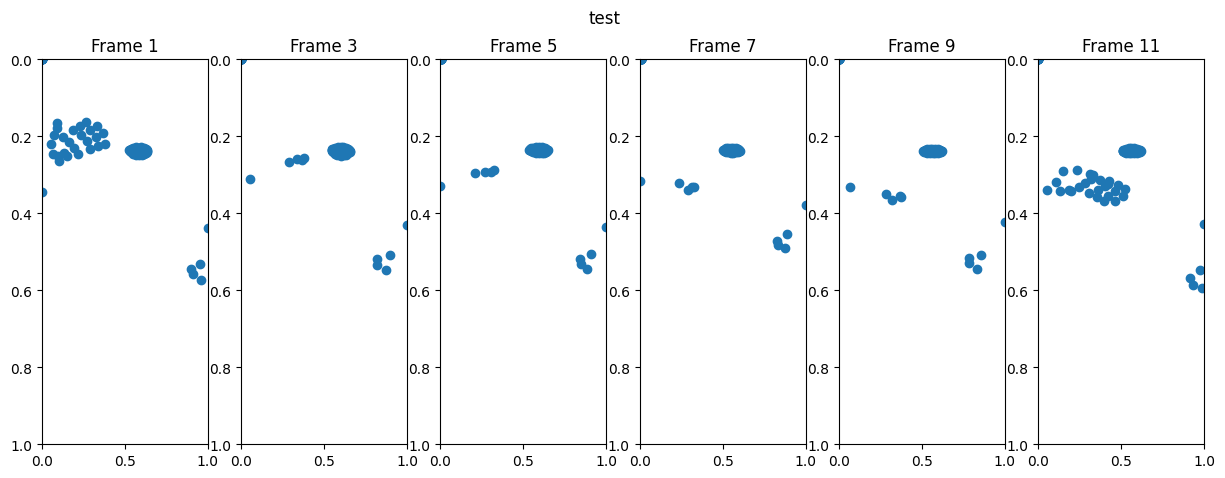

In [183]:
sequence = dataset[1][0]
n_frames, n_landmarks = len(sequence), 92

pad = int(n_frames/5)

frames_to_plot = n_frames

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
c=0
for i in range(frames_to_plot):
    if i%pad==0:
        X = np.array([sequence[i][j][0] for j in range(n_landmarks)])
        Y = np.array([sequence[i][j][1] for j in range(n_landmarks)])
        axes[c].scatter(X, Y)
        axes[c].set_xlim(0, 1)  # Assuming coordinates are normalized between 0 and 1
        axes[c].set_ylim(0, 1)
        axes[c].set_title(f'Frame {i+1}')
        axes[c].invert_yaxis()  # Invert y-axis if needed to match coordinate system
        c+=1

plt.suptitle('test')
# plt.tight_layout()
plt.show()

In [ ]:
sqc = dataset[0][0]

In [151]:
len(sqc[10])

92

In [182]:
dataset[0][1]

'blow'